# **💼 Capstone Project: Predicting Developer Salaries Using Stack Overflow Survey Data (2023–2024)**

---

## 🧠 Business Understanding

### 🎯 Project Objective
Build a machine learning model that predicts annual developer salaries using demographic, professional, and technical features. We leverage Stack Overflow’s 2023 and 2024 survey datasets to inform both global and localized (Kenyan) compensation insights.

### ❓ Why This Matters
Salary transparency is limited in many global regions — especially across Africa. Developers often navigate job transitions, promotions, or freelance pricing without reliable benchmarks. This model aims to provide data-driven insights that help both job seekers and hiring managers make informed compensation decisions.

This model helps:
- Developers **benchmark expected compensation**
- Employers **set fair, competitive pay**
- Career changers **evaluate the ROI of learning paths**
- HR platforms **integrate salary prediction engines**
- Policymakers and analysts **understand wage trends in tech**

### 🌍 Kenya-Specific Relevance
In Kenya, tech hubs like Nairobi are booming — yet salary data remains fragmented. This model could:
- Help junior/mid-level developers negotiate better
- Empower remote-first hiring with global salary range visibility
- Be integrated into job platforms like **Fuzu**, **BrighterMonday**, or **Andela**

### 🧑‍💻 Industry Domains
- **Primary**: Technology
- **Secondary**: Human Capital Analytics, Labor Market Research

### 👥 Stakeholders

| Stakeholder Group         | Value Proposition                                                                 |
|---------------------------|------------------------------------------------------------------------------------|
| Developers                | Benchmark realistic compensation based on skills and experience                   |
| Employers & Recruiters    | Offer data-driven, competitive salaries                                            |
| HR Tech Platforms         | Integrate model into job boards or career guidance tools                          |
| Bootcamps & Career Coaches| Showcase expected returns on upskilling efforts                                   |
| Policy & Advocacy Groups  | Inform labor market planning and economic inclusion initiatives                   |

### 🔬 Literature & Prior Work
This project builds on:
- Previous Stack Overflow Salary Calculators (now deprecated)
- ML-based salary models using Random Forest, XGBoost, etc.
- Global developer reports (GitHub Octoverse, Dev.to, HackerRank)

### ✨ Unique Contribution
- Combines recent **multi-year (2023 & 2024)** datasets
- Applies **localized lens** for Kenya/Africa
- Prioritizes **real-world use cases** for talent, HR, and learning ecosystems

---

## 📊 Data Understanding

### 📁 Data Sources
- `survey_results_public_2023.csv`
- `survey_results_public_2024.csv`

Source: [Stack Overflow Developer Survey](https://insights.stackoverflow.com/survey)

### 📐 Data Summary

| Year | Total Responses | Countries | SSA Responses | Kenya Responses |
|------|------------------|-----------|----------------|------------------|
| 2023 | ~89,000          | ~180      | 1,828          | 244              |
| 2024 | ~65,000          | ~188      | 1,271          | 180              |

Combined, we expect **100,000+ usable rows** across ~188 countries.

### 🔑 Key Features

| Category        | Variables (examples)                                                  |
|----------------|------------------------------------------------------------------------|
| Demographics    | `Age`, `Country`, `Gender`                                             |
| Education       | `EdLevel`, `LearnCode`, `YearsCodePro`                                 |
| Employment      | `Employment`, `OrgSize`, `RemoteWork`                                  |
| Technical Tools | `LanguageHaveWorkedWith`, `PlatformHaveWorkedWith`, `AISelect`         |
| Target Variable | `ConvertedCompYearly` (Annual salary in USD)                           |
| Meta Info       | `SurveyYear`, `Currency`                                               |

### ⚠️ Data Limitations & Mitigation Strategies

| Limitation                             | Proposed Mitigation                                           |
|----------------------------------------|---------------------------------------------------------------|
| Schema changes between years           | Focus on **common columns**; map others as needed             |
| Imbalanced country distribution        | Consider **oversampling**, stratified models                  |
| Salary skew and outliers               | Apply **log transformation**, drop outliers via IQR/z-score   |
| Sparse Kenya data                      | Enrich with African subset or train global model              |
| Missing values                         | Drop, impute, or bin categories during preprocessing          |

### 💾 Planned Enhancements
- Add `SurveyYear` column to track year-based differences
- Combine datasets using common schema
- Analyze **Kenya**, **Nigeria**, and **South Africa** as focus regions
- Consider integrating external salary platforms like Glassdoor KE

---

📝 **Next Up**: Exploratory Data Analysis (EDA), Feature Engineering, and Baseline Modeling.

In [1]:
# Import relevant libraries
# warnings
import warnings
warnings.filterwarnings('ignore')
# data handling
import pandas as pd 
import numpy as np
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# models
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# explainability
import shap
# utilities
import os
from pathlib import Path
# feature selection and importance
from sklearn.feature_selection import SelectKBest, f_regression

### 📥 Load 2023 & 2024 Stack Overflow Survey Data

In [2]:
# loading the 2023 and 2024 datasets
df_2023 = pd.read_csv('survey_results_public_2023.csv')
df_2024 = pd.read_csv('survey_results_public_2024.csv')


### 🧩 2. Understand Schema Differences Between the Two Years

In [3]:

print(df_2023.columns.difference(df_2024.columns))
print(df_2024.columns.difference(df_2023.columns))

Index(['AIDevHaveWorkedWith', 'AIDevWantToWorkWith',
       'AINextNeither different nor similar', 'AINextSomewhat different',
       'AINextSomewhat similar', 'AINextVery different', 'AINextVery similar',
       'AISearchHaveWorkedWith', 'AISearchWantToWorkWith',
       'LearnCodeCoursesCert', 'Q120', 'SOAI', 'TechList'],
      dtype='object')
Index(['AIChallenges', 'AIComplex', 'AIEthics', 'AINextLess integrated',
       'AINextMore integrated', 'AINextMuch less integrated',
       'AINextMuch more integrated', 'AINextNo change', 'AISearchDevAdmired',
       'AISearchDevHaveWorkedWith', 'AISearchDevWantToWorkWith', 'AIThreat',
       'BuildvsBuy', 'Check', 'DatabaseAdmired', 'EmbeddedAdmired',
       'EmbeddedHaveWorkedWith', 'EmbeddedWantToWorkWith', 'Frustration',
       'JobSat', 'JobSatPoints_1', 'JobSatPoints_10', 'JobSatPoints_11',
       'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7',
       'JobSatPoints_8', 'JobSatPoints_9', 'Knowledge_9', 'LanguageAd

Stack Overflow's survey questions vary slightly each year. We checked for columns that appear in one year but not the other. This helps us align the two datasets before combining them.

In [5]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode                   

In [6]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 56.9+ MB


### 🏗️ 3. Merge Datasets for a Unified View

In [7]:
# Add SurveyYear column to distinguish entries
df_2023['SurveyYear'] = 2023
df_2024['SurveyYear'] = 2024

# Align column structure by filling in missing columns in each dataset
missing_2023 = df_2024.columns.difference(df_2023.columns)
missing_2024 = df_2023.columns.difference(df_2024.columns)

# Add missing columns to each dataframe and fill with NaN
for col in missing_2023:
    df_2023[col] = np.nan

for col in missing_2024:
    df_2024[col] = np.nan

# Reorder columns to match, important for concat
df_2023 = df_2023[df_2024.columns]

# Concatenate
df_all = pd.concat([df_2023, df_2024], ignore_index=True)

print(f"Merged shape: {df_all.shape}")


Merged shape: (154621, 128)


We combined the 2023 and 2024 survey responses into one large dataset. To make this possible, we added any missing questions from one year into the other using empty values (NaNs).

### Feature Selection Justification

In [ ]:
# Define relevant features for salary prediction (features selected using relevance and domain intuition)
selected_features = [
    'Country', 'Employment', 'RemoteWork', 'OrgSize', 'ICorPM',
    'YearsCodePro', 'DevType', 'EdLevel', 'Industry', 
    'PurchaseInfluence', 'LanguageHaveWorkedWith', 'PlatformHaveWorkedWith',
    'ToolsTechHaveWorkedWith', 'ConvertedCompYearly', 'SurveyYear', 'AIThreat'
]

# Subset and copy data
df = df_all[selected_features].copy()

# Drop missing or unrealistic target values
df = df[df['ConvertedCompYearly'].notna()]
df = df[df['ConvertedCompYearly'] > 1000]  # Filter extremely low salaries

# Handle missing categorical values
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna('Missing')

# Clean numeric features
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')
df['YearsCodePro'] = df['YearsCodePro'].fillna(df['YearsCodePro'].median())

print(f"✅ Final Cleaned Data Shape: {df.shape}")


✅ Final Cleaned Data Shape: (70215, 16)


## Exploratory Data Analysis

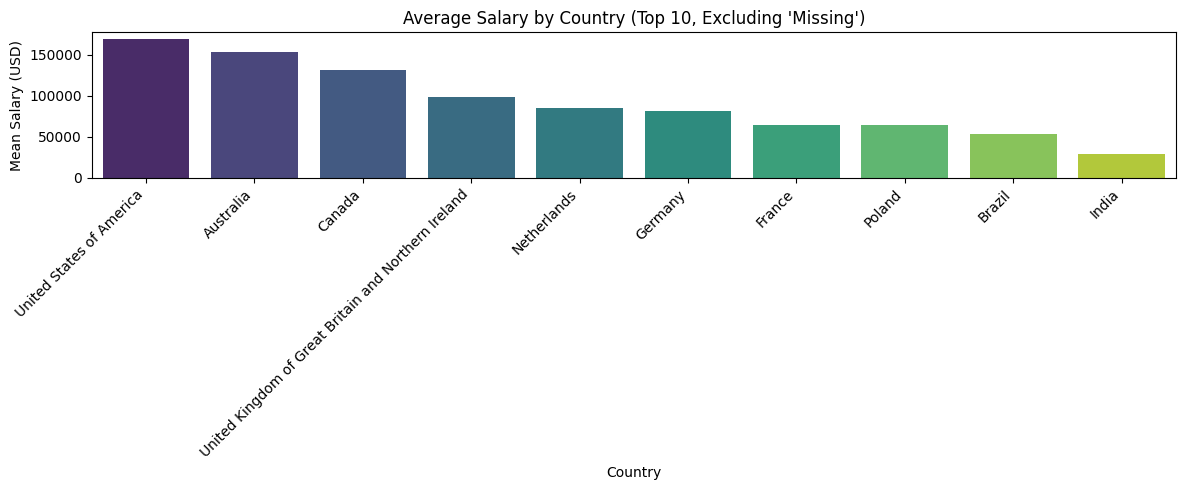

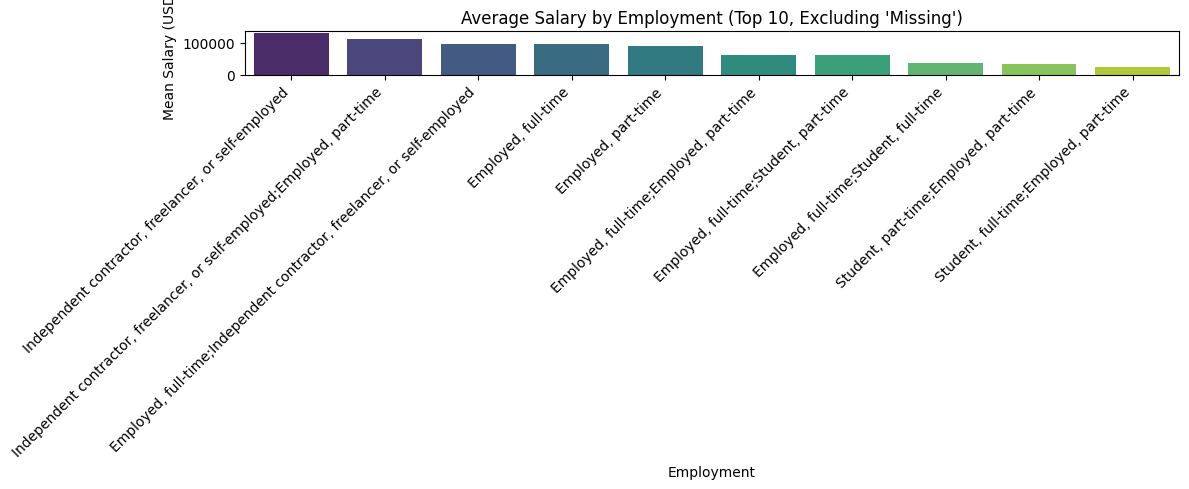

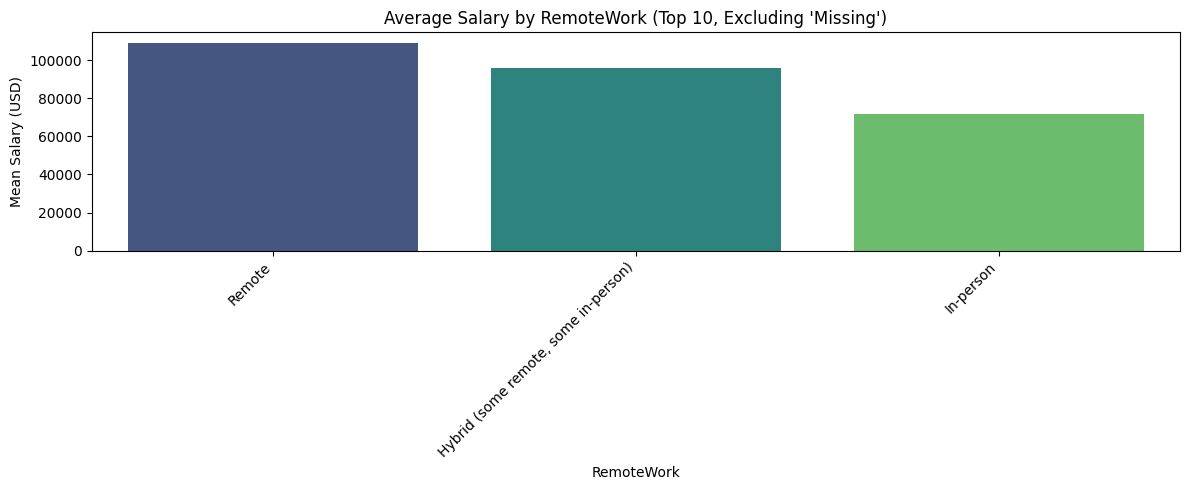

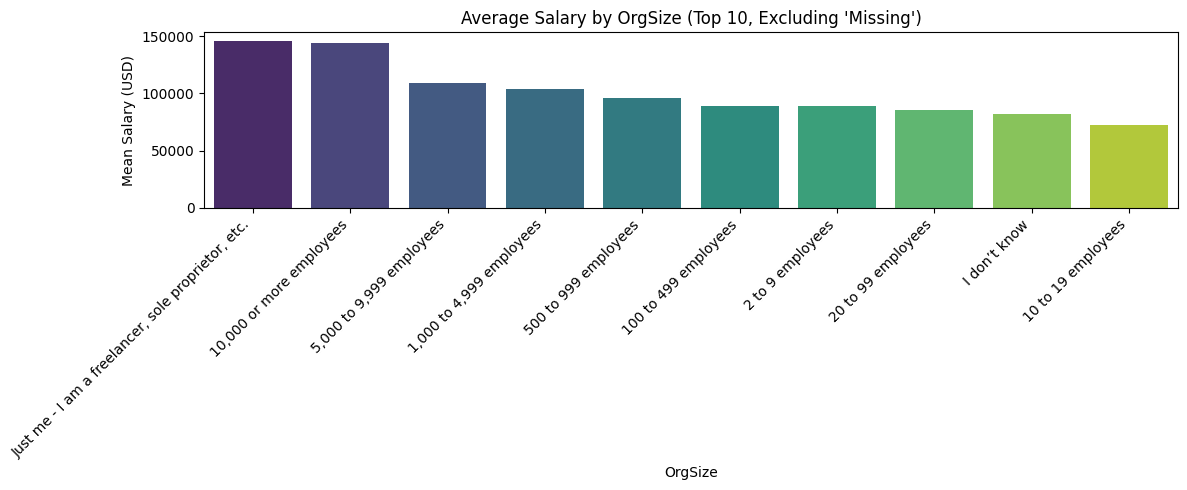

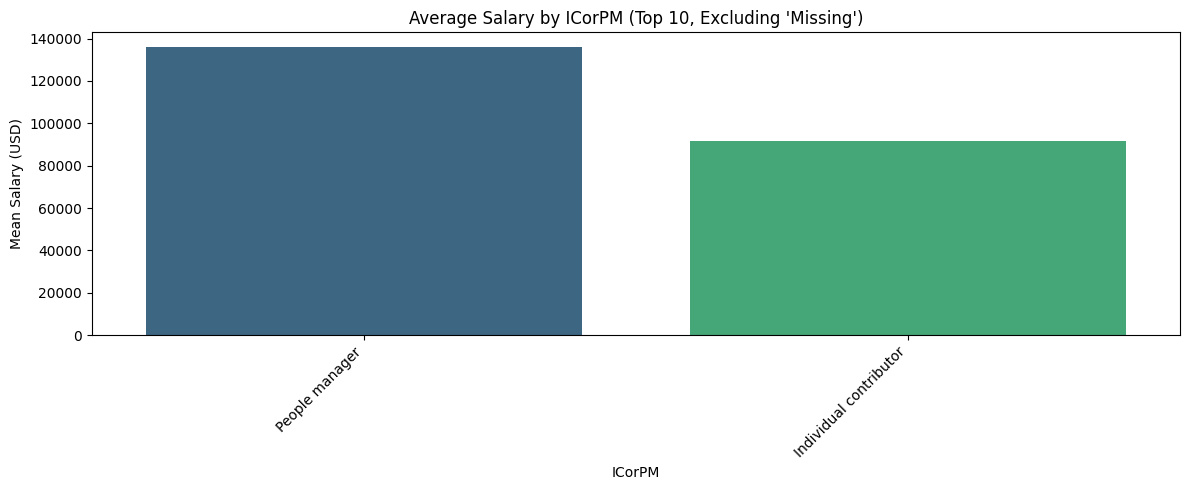

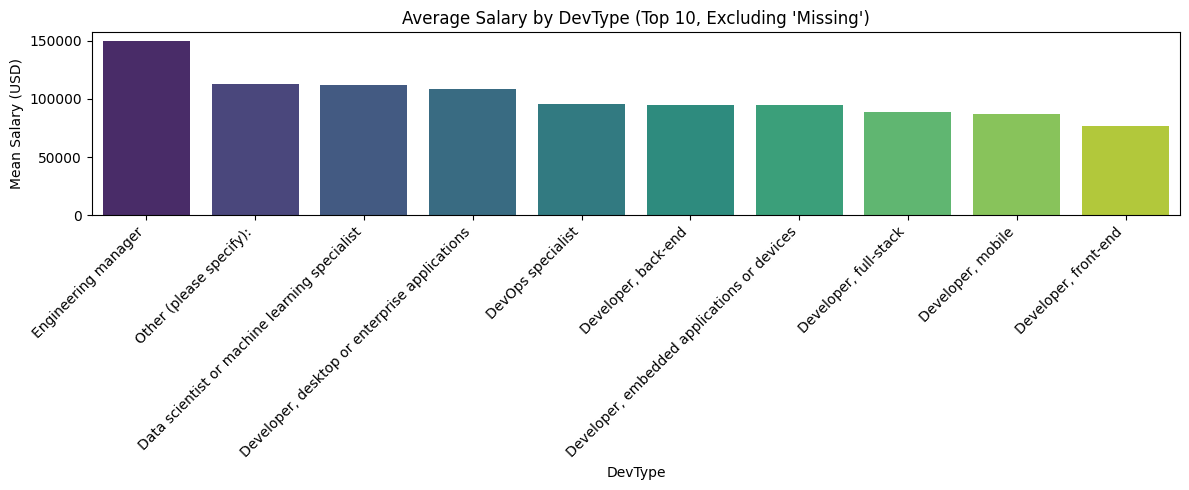

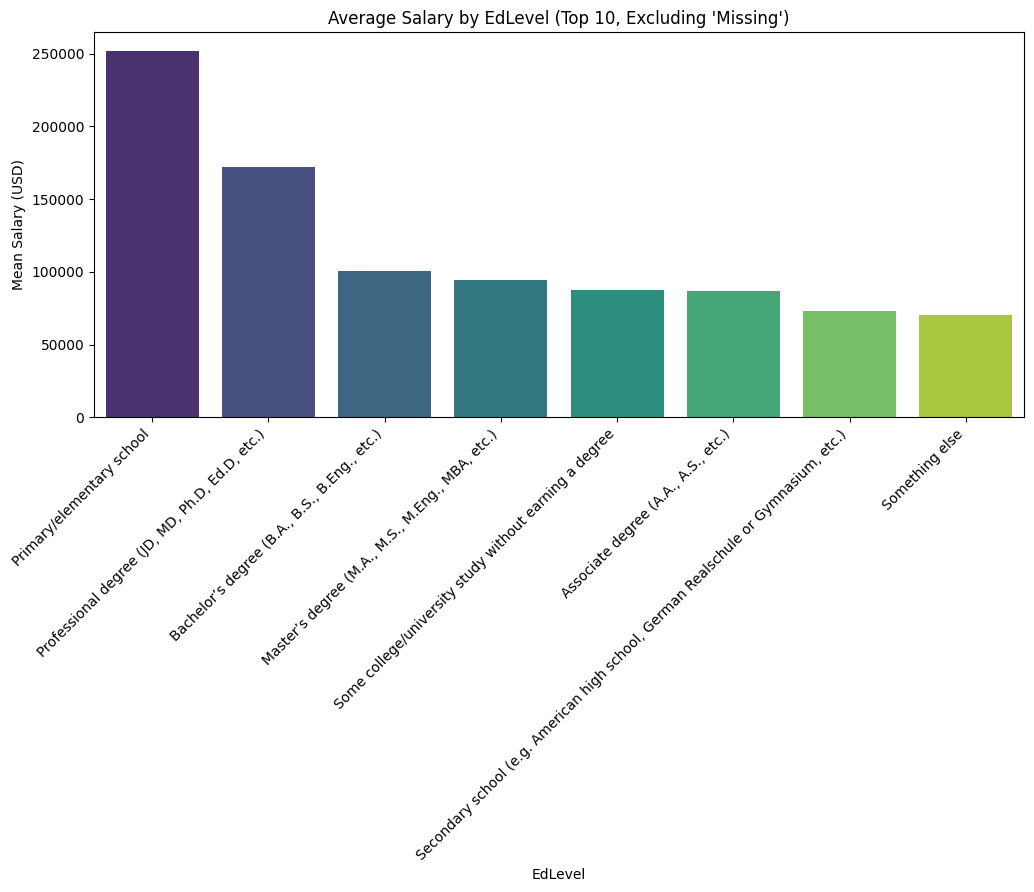

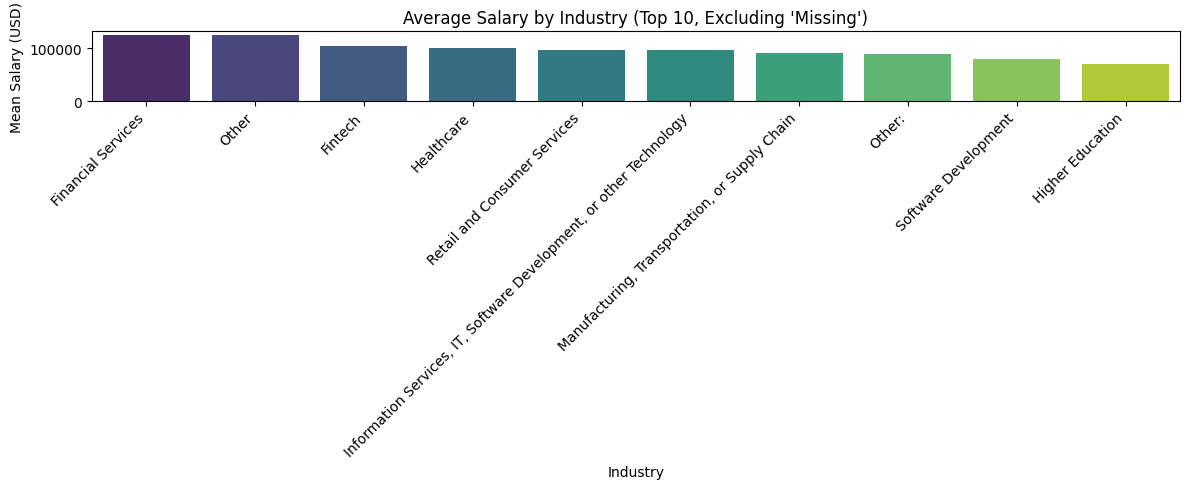

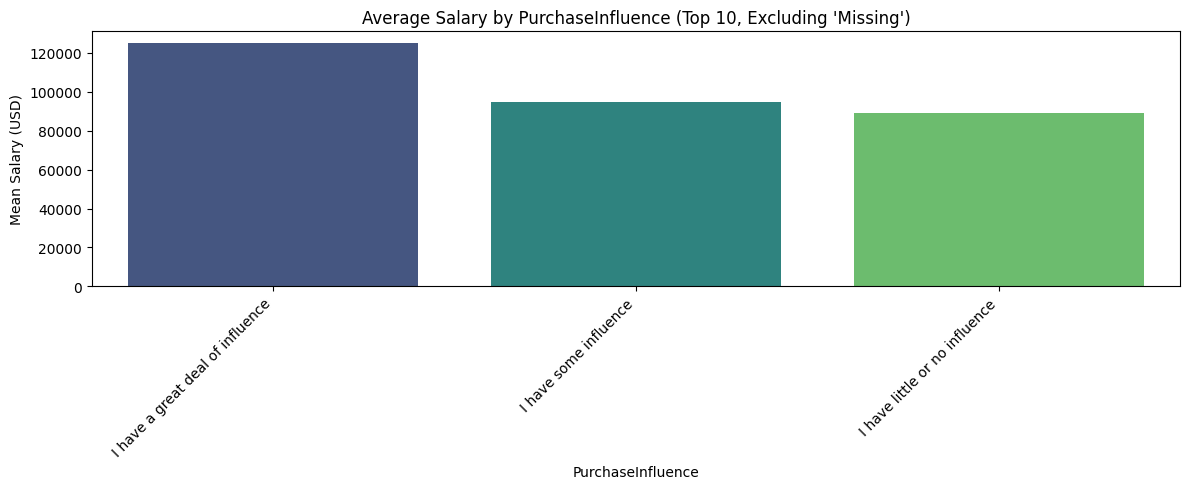

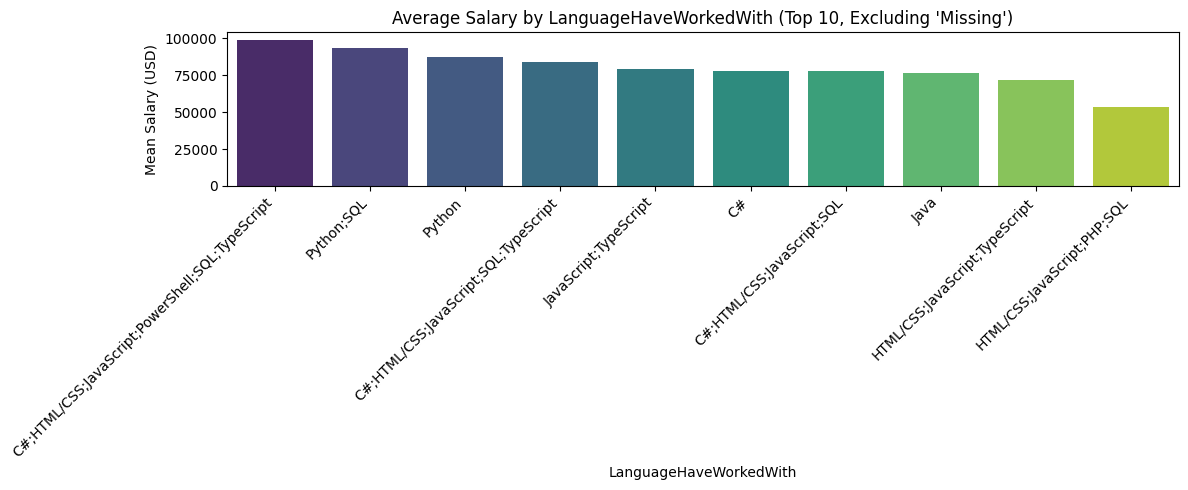

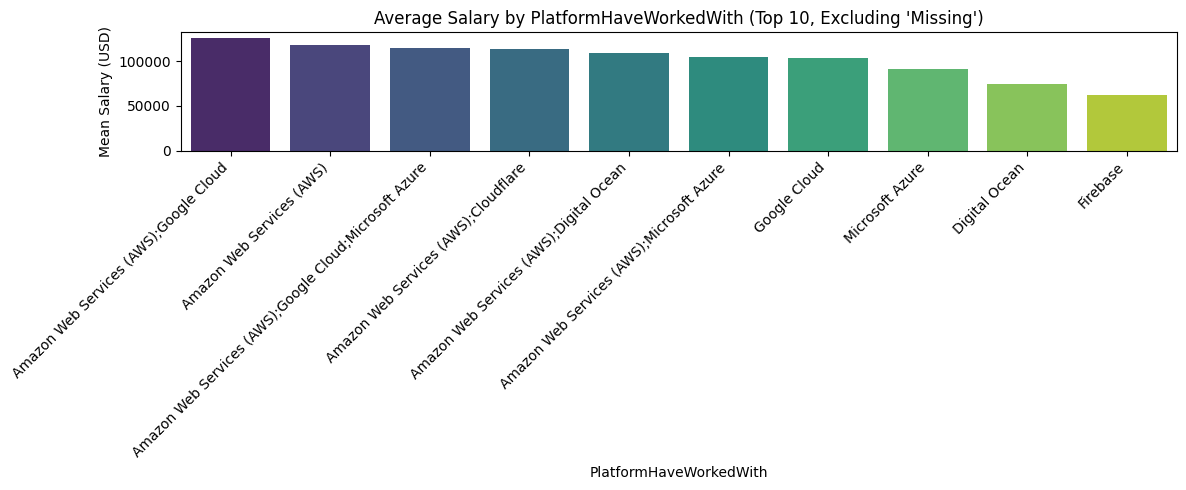

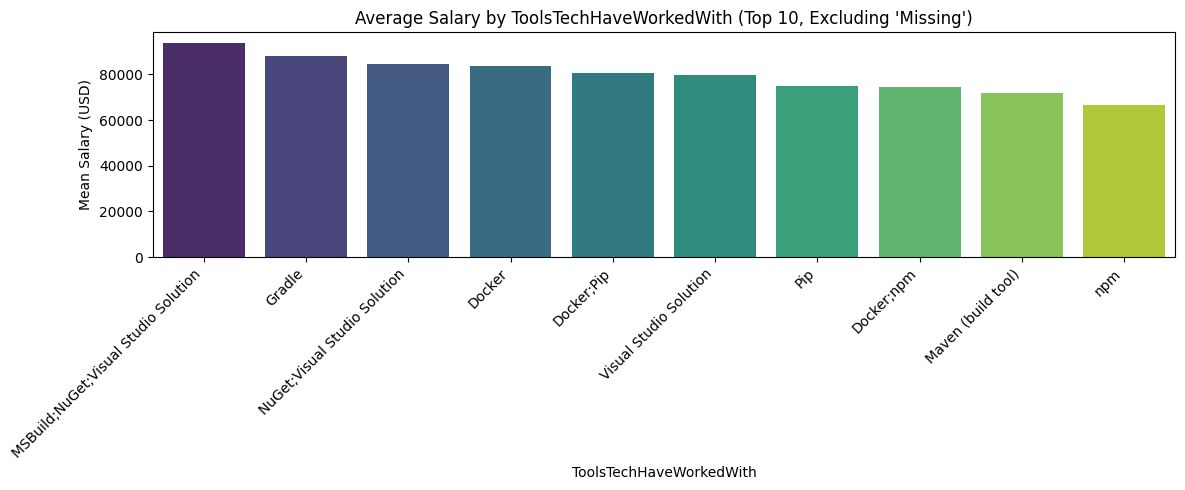

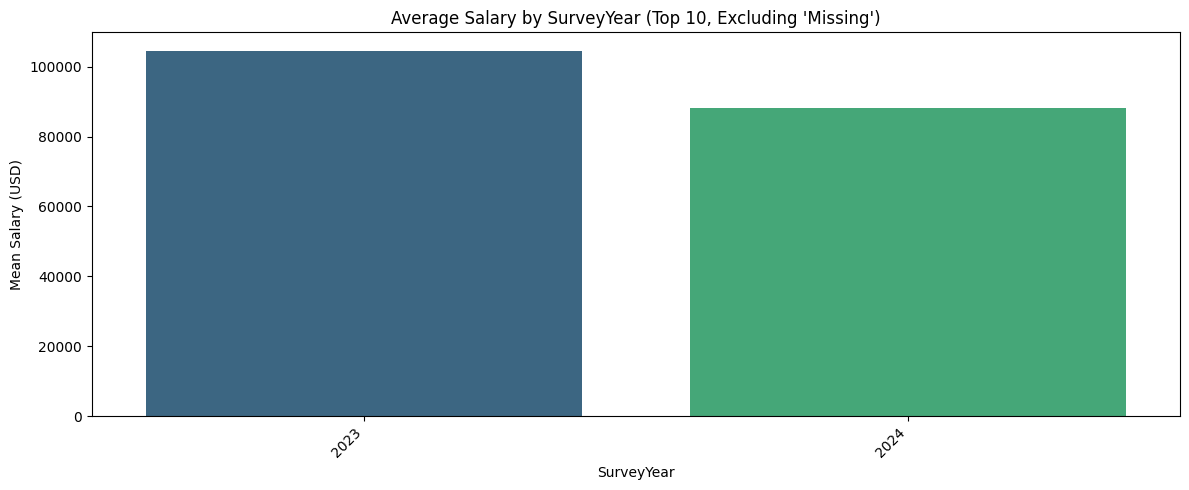

In [17]:
categorical_features = ['Country', 'Employment', 'RemoteWork', 'OrgSize', 'ICorPM', 
                        'DevType', 'EdLevel', 'Industry', 'PurchaseInfluence',
                        'LanguageHaveWorkedWith', 'PlatformHaveWorkedWith', 
                        'ToolsTechHaveWorkedWith', 'SurveyYear']

for feature in categorical_features:
    plt.figure(figsize=(12,5))

    # Filter out 'Missing' values first
    df_filtered = df[df[feature] != 'Missing']

    # Get top categories by frequency
    top_categories = df_filtered[feature].value_counts().nlargest(10).index

    # Filter to top categories
    filtered_df = df_filtered[df_filtered[feature].isin(top_categories)]

    # Compute mean salary per category, sorted by salary
    sorted_order = (
        filtered_df.groupby(feature)['ConvertedCompYearly']
        .mean()
        .sort_values(ascending=False)
        .index
    )

    sns.barplot(
        data=filtered_df,
        x=feature,
        y='ConvertedCompYearly',
        estimator=np.mean,
        ci=None,
        order=sorted_order,
        palette='viridis'
    )

    plt.title(f"Average Salary by {feature} (Top 10, Excluding 'Missing')")
    plt.ylabel("Mean Salary (USD)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


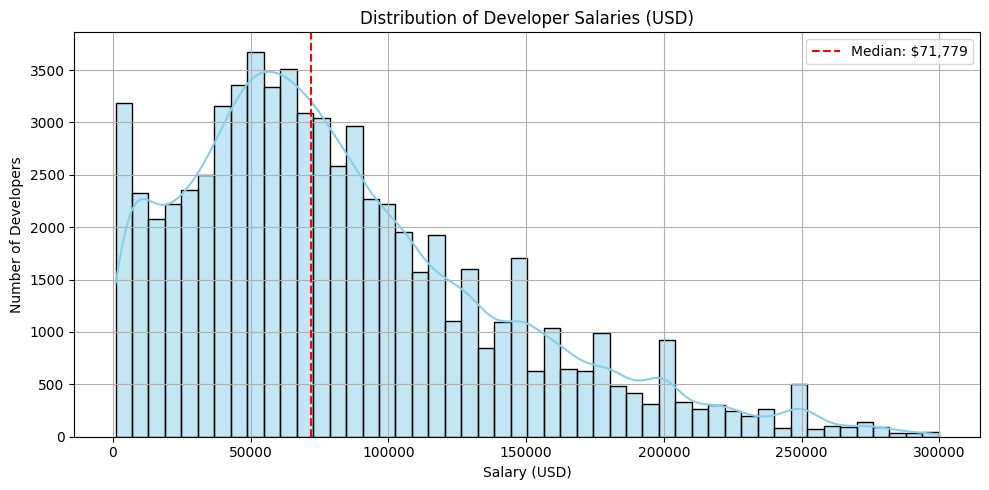

In [14]:
# Clean data
clean_salary = df['ConvertedCompYearly'].dropna()
clean_salary = clean_salary[clean_salary > 1000]  # Remove very low outliers
clean_salary = clean_salary[clean_salary < 300000]  # Cap extreme values

# Plot
plt.figure(figsize=(10,5))
sns.histplot(clean_salary, bins=50, kde=True, color='skyblue')
plt.axvline(clean_salary.median(), color='red', linestyle='--', label=f"Median: ${int(clean_salary.median()):,}")
plt.title("Distribution of Developer Salaries (USD)")
plt.xlabel("Salary (USD)")
plt.ylabel("Number of Developers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✍️ Interpretation  
Salaries tend to cluster between $30,000 and $100,000 per year, with a few very high earners pulling the average upward. This is known as a right-skewed distribution, most developers earn within a moderate range, while a few outliers earn significantly more.

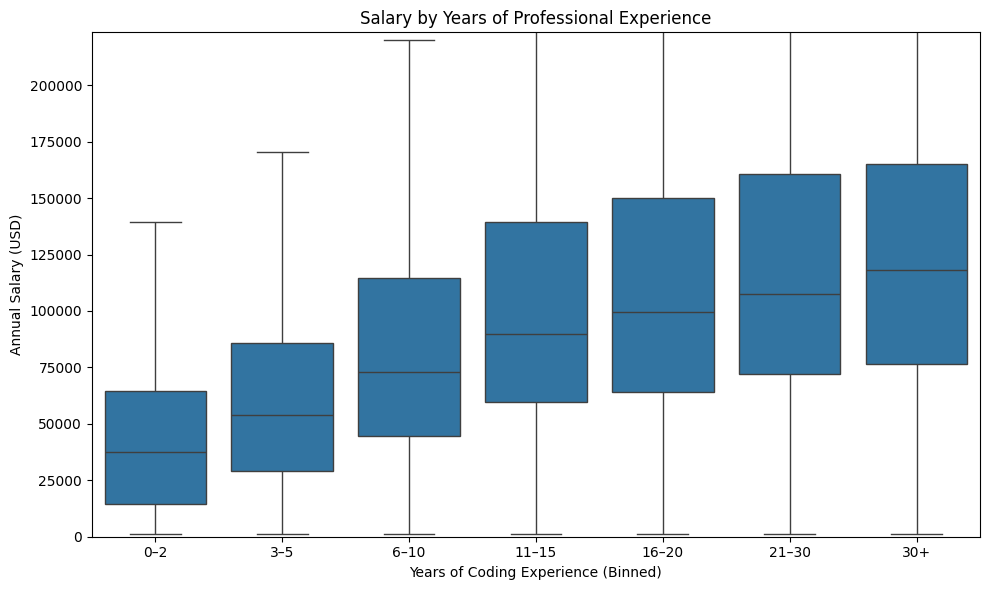

In [13]:
## Salary by years of professional experience
# Filter: Remove missing or unrealistic salary/experience
salary_exp_df = df[
    df['ConvertedCompYearly'].notna() & 
    df['YearsCodePro'].notna()
].copy()

# Bin YearsCodePro for clarity
salary_exp_df['ExperienceBin'] = pd.cut(
    salary_exp_df['YearsCodePro'],
    bins=[0, 2, 5, 10, 15, 20, 30, 50],
    labels=['0–2', '3–5', '6–10', '11–15', '16–20', '21–30', '30+']
)

# Plot
plt.figure(figsize=(10,6))
sns.boxplot(data=salary_exp_df, x='ExperienceBin', y='ConvertedCompYearly', showfliers=False)
plt.title('Salary by Years of Professional Experience')
plt.xlabel('Years of Coding Experience (Binned)')
plt.ylabel('Annual Salary (USD)')
plt.ylim(0, salary_exp_df['ConvertedCompYearly'].quantile(0.95))  # Remove extreme outliers
plt.tight_layout()
plt.show()


The graph shows a clear positive correlation between years of professional experience and annual salary. 
As experience increases, salaries tend to rise steadily.



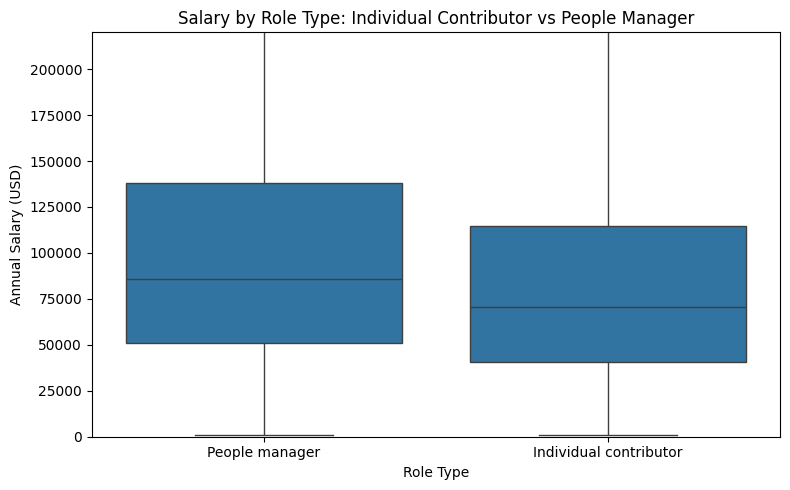

In [14]:
## Salary by ICorPM (Individual Contributor vs People Manager)
# Filter to remove missing or "Missing" values
ic_pm_df = df[
    df['ConvertedCompYearly'].notna() &
    df['ICorPM'].notna() &
    (df['ICorPM'] != 'Missing')
].copy()

# Plot salary distribution by ICorPM
plt.figure(figsize=(8,5))
sns.boxplot(
    data=ic_pm_df,
    x='ICorPM',
    y='ConvertedCompYearly',
    showfliers=False  # hides extreme outliers
)

plt.title('Salary by Role Type: Individual Contributor vs People Manager')
plt.xlabel('Role Type')
plt.ylabel('Annual Salary (USD)')
plt.ylim(0, ic_pm_df['ConvertedCompYearly'].quantile(0.95))  # limit y-axis to 95th percentile
plt.tight_layout()
plt.show()


The average annual salary for a People Manager role is significantly higher than the average salary for an Individual Contributor role. The graph shows a clear gap between the two.

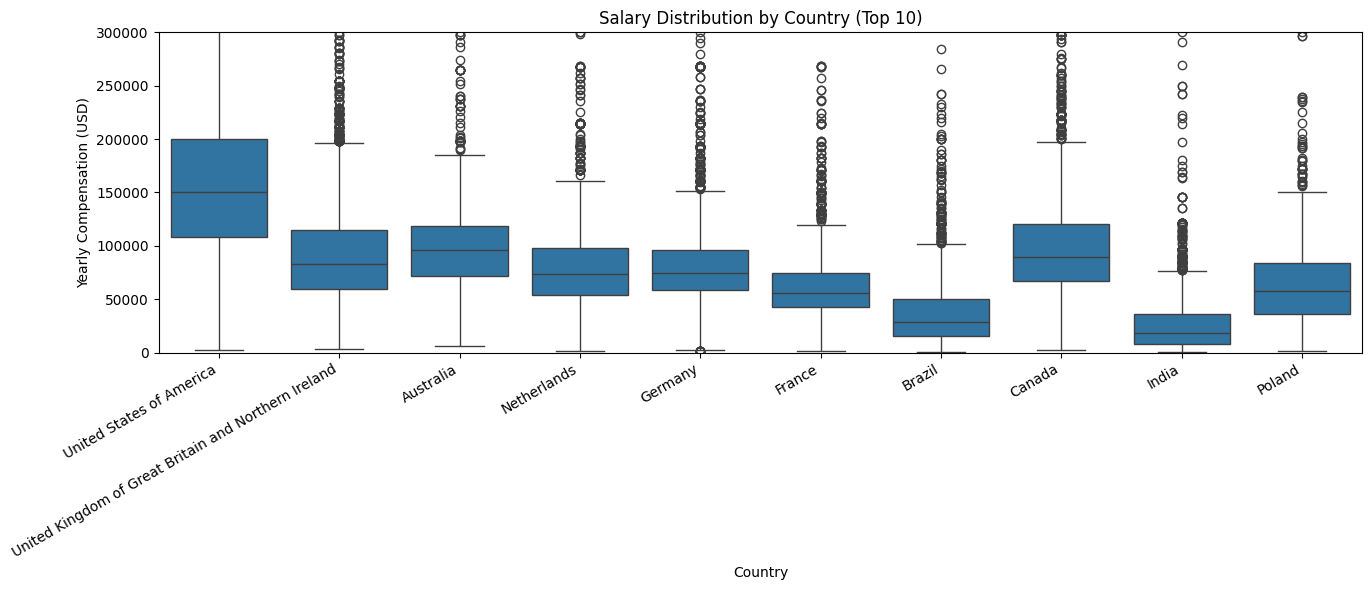

In [15]:
# Salary distribution by country (Top 10)
# Get top 10 countries by frequency
top_countries = df['Country'].value_counts().head(10).index

plt.figure(figsize=(14,6))
sns.boxplot(
    data=df[df['Country'].isin(top_countries)],
    x='Country',
    y='ConvertedCompYearly'
)

plt.xticks(rotation=30, ha='right')
plt.ylim(0, 300000) 
plt.title("Salary Distribution by Country (Top 10)")
plt.xlabel("Country")
plt.ylabel("Yearly Compensation (USD)")
plt.tight_layout()
plt.show()




The graph illustrates significant differences in the salary ranges between the top 10 countries. Some countries like the United States and Canada have a much wider salary distribution, while others like Poland and India have a more compressed range.

### AIThreat vs Selected Features


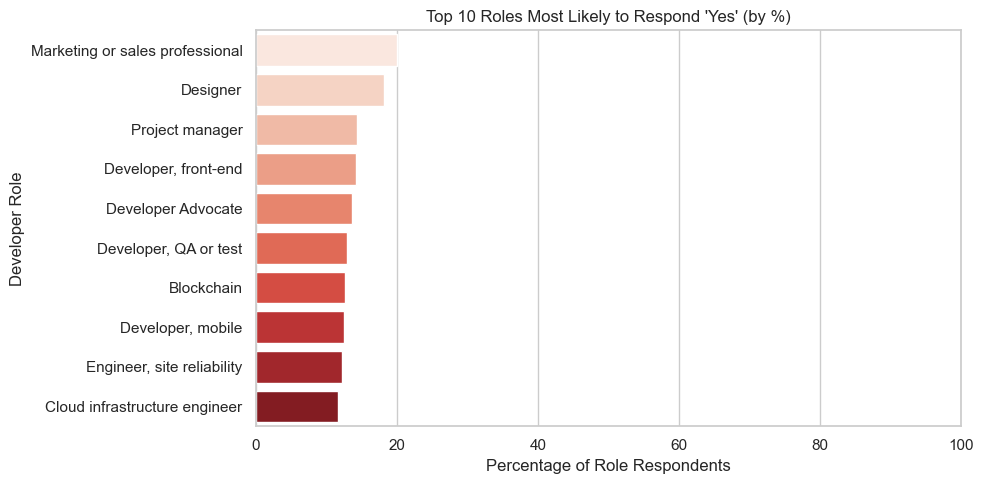

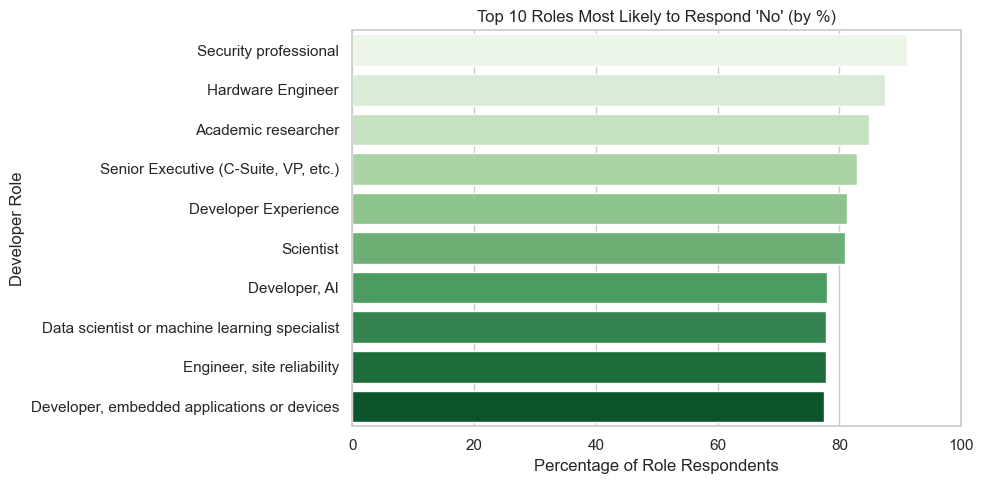

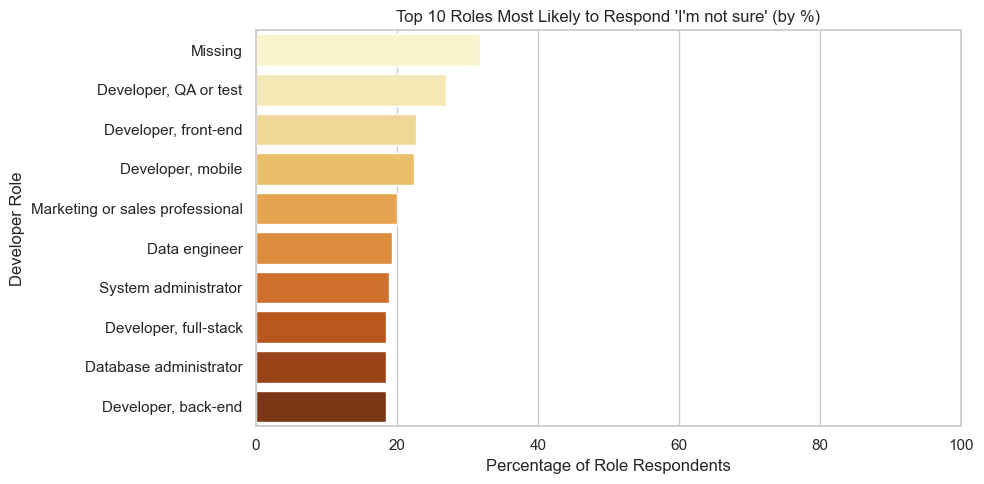

In [17]:
# Filter clean data
valid_ai_responses = ["Yes", "No", "I'm not sure"]
df_ai = df[df['AIThreat'].isin(valid_ai_responses)].copy()

# Prepare DevType column
df_ai = df_ai.dropna(subset=['DevType'])
df_ai['DevType'] = df_ai['DevType'].str.split(';')
df_ai = df_ai.explode('DevType')
df_ai['DevType'] = df_ai['DevType'].str.strip()

# Normalize role threat responses
# Total count of each role overall
role_totals = df_ai['DevType'].value_counts()

# Function to calculate top 10 roles by percentage for a given threat category
def get_top_roles(threat_label, color):
    threat_df = df_ai[df_ai['AIThreat'] == threat_label]
    role_counts = threat_df['DevType'].value_counts()
    role_percent = (role_counts / role_totals * 100).dropna()
    top_roles = role_percent.nlargest(10)
    
    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=top_roles.values,
        y=top_roles.index,
        palette=color
    )
    plt.title(f"Top 10 Roles Most Likely to Respond '{threat_label}' (by %)")
    plt.xlabel("Percentage of Role Respondents")
    plt.ylabel("Developer Role")
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()
    
    return top_roles

# Step 4: Run for each category
top_yes = get_top_roles("Yes", "Reds")
top_no = get_top_roles("No", "Greens")
top_unsure = get_top_roles("I'm not sure", "YlOrBr")



Sub-Saharan Median Salary (USD): 19478.5


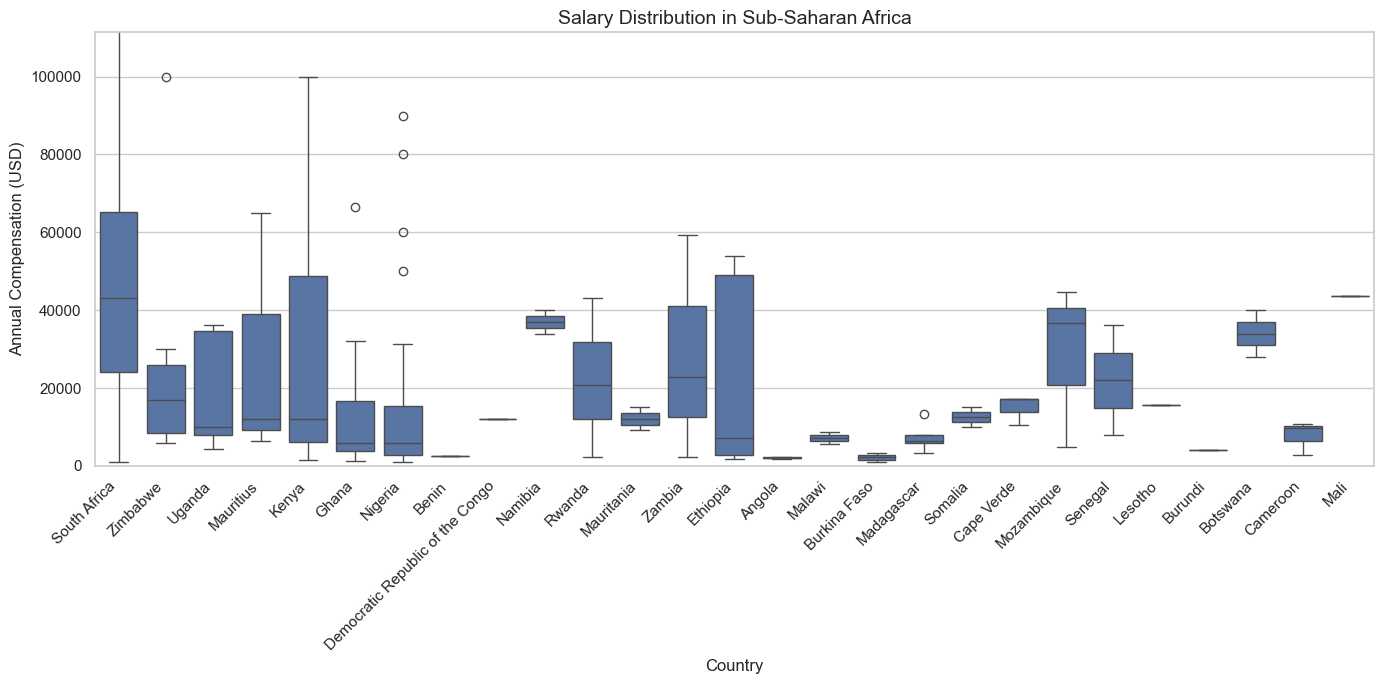

In [28]:
# Sub-Saharan Africa Salary Distribution Boxplot
ssa_countries = [
    'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cape Verde', 'Cameroon',
    'Central African Republic', 'Chad', 'Comoros', 'Democratic Republic of the Congo', 'Congo',
    'Côte d’Ivoire', 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
    'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
    'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique', 'Namibia',
    'Niger', 'Nigeria', 'Rwanda', 'São Tomé and Príncipe', 'Senegal', 'Seychelles', 
    'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 
    'Togo', 'Uganda', 'Zambia', 'Zimbabwe'
]

# Filter data
ssa_df = df_ai[
    df_ai['Country'].isin(ssa_countries) &
    df_ai['ConvertedCompYearly'].notna() &
   df_ai['AIThreat'].isin(valid_ai_responses)
]

# Print summary
print("Sub-Saharan Median Salary (USD):", ssa_df['ConvertedCompYearly'].median())

# Boxplot
plt.figure(figsize=(14, 7))  # Increased width
sns.boxplot(data=ssa_df, x='Country', y='ConvertedCompYearly')
plt.title('Salary Distribution in Sub-Saharan Africa', fontsize=14)
plt.ylabel('Annual Compensation (USD)')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')  # Better label alignment
plt.ylim(0, ssa_df['ConvertedCompYearly'].quantile(0.95))  # Remove extreme outliers for visibility
plt.tight_layout()
plt.show()

South Africa has the highest annual compensation levels, with the top end reaching around $80,000.

Countries like Zimbabwe, Uganda, Kenya, and Ghana have salary distributions in the $30,000 to $50,000 range.

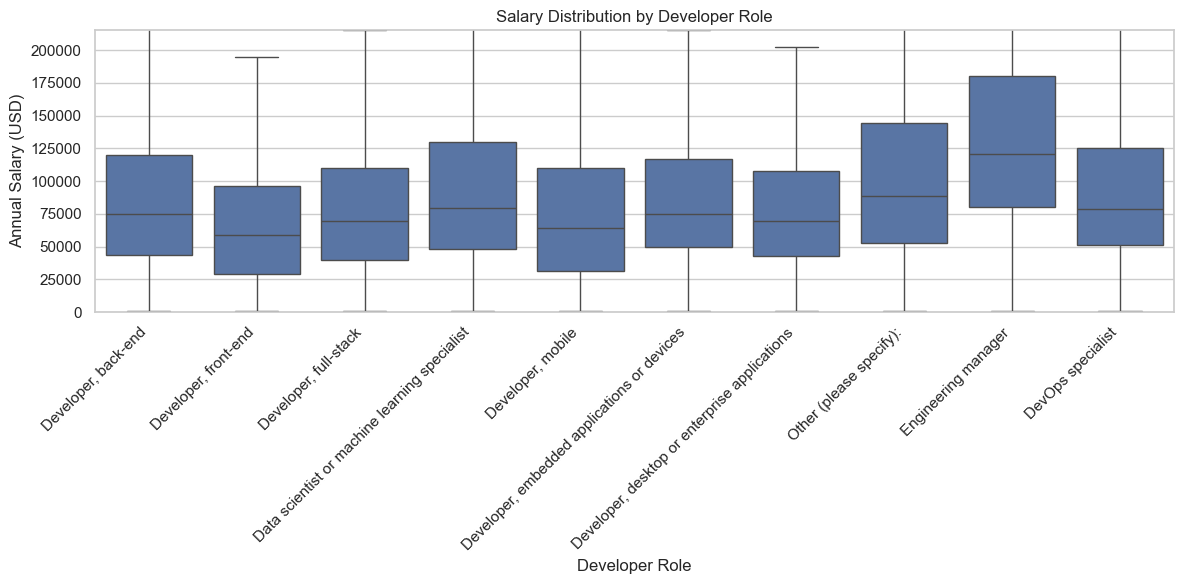

In [19]:
## Salary Distribution by Developer Role (DevType)
# Filter: keep rows with salary and DevType info
role_df = df[
    df['ConvertedCompYearly'].notna() &
    df['DevType'].notna() &
    (df['DevType'] != 'Missing')
].copy()

# Optional: Limit to top 10 most common roles to make the plot readable
top_roles = role_df['DevType'].value_counts().nlargest(10).index
role_df = role_df[role_df['DevType'].isin(top_roles)]

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=role_df,
    x='DevType',
    y='ConvertedCompYearly',
    showfliers=False
)

plt.title('Salary Distribution by Developer Role')
plt.xlabel('Developer Role')
plt.ylabel('Annual Salary (USD)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, role_df['ConvertedCompYearly'].quantile(0.95))  # Clip top 5% to reduce skew
plt.tight_layout()
plt.show()



The roles with the highest salary ranges are Engineering Manager, DevOps Specialist, and Other (please specify). These roles seem to have the potential for the highest annual compensation, reaching up to around $175,000 or more.

## Preprocessing for Modeling 

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Define target
y = df['ConvertedCompYearly']
X = df.drop(columns='ConvertedCompYearly')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Identify features
num_feats = ['YearsCodePro']
cat_feats = [col for col in X.columns if col not in num_feats]

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_feats),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_feats)
])


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# 1. Define features & target
features = ['Country', 'YearsCodePro', 'EdLevel', 'RemoteWork']
target = 'ConvertedCompYearly'

X = df[features]
y = df[target]

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 3. Separate numerical and categorical features
num_features = ['YearsCodePro']
cat_features = ['Country', 'EdLevel', 'RemoteWork']

# 4. Build preprocessing transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# 5. Combine into pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

# 6. Train the model
lr_pipeline.fit(X_train, y_train)

# 7. Evaluate
y_pred = lr_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Linear Regression MAE: {mae:,.0f}")

Linear Regression MAE: 48,844


## Model Training and Evaluation

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Create pipeline
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.3f}")


KeyboardInterrupt: 

## Feature Importance

In [ ]:
# Access trained model and get importances
rf_model = model.named_steps['regressor']
ohe = model.named_steps['preprocessing'].named_transformers_['cat'].named_steps['encoder']
feature_names = ohe.get_feature_names_out(cat_feats).tolist() + num_feats

importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()


## 🧠 SHAP Explainability + Localized Insights

In [ ]:
# 🧪 Train Final Model
from xgboost import XGBRegressor

# Features and target
X = combined[selected_features]
y = combined['ConvertedCompYearly']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# Pipeline for numeric + categorical handling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

model.fit(X_train, y_train)



In [ ]:
# SHAP: Global Explainability
import shap
explainer = shap.Explainer(model.named_steps['xgb'])
# Transform the features before SHAP (post-pipeline)
X_transformed = model.named_steps['preprocess'].transform(X_test)
shap_values = explainer(X_transformed)

# SHAP summary plot
shap.summary_plot(shap_values, X_transformed, feature_names=preprocessor.get_feature_names_out())


In [10]:
# Number of responses from Kenya in 2023
kenya_2023 = df_2023[df_2023['Country'] == 'Kenya']
print("2023 Kenya responses:", kenya_2023.shape[0])

# Number of responses from Kenya in 2024
kenya_2024 = df_2024[df_2024['Country'] == 'Kenya']
print("2024 Kenya responses:", kenya_2024.shape[0])

# Number of responses from Africa's Big 3 countries in 2023
big_3_countries = ['Kenya', 'Nigeria', 'South Africa']
big_3_2023 = df_2023[df_2023['Country'].isin(big_3_countries)]
print("2023 Big 3 responses:", big_3_2023.shape[0])

# Number of responses from Africa's Big 3 countries in 2024
big_3_2024 = df_2024[df_2024['Country'].isin(big_3_countries)]
print("2024 Big 3 responses:", big_3_2024.shape[0])

2023 Kenya responses: 244
2024 Kenya responses: 180
2023 Big 3 responses: 1264
2024 Big 3 responses: 843


In [26]:
# Unique countries in df_2023
countries_2023 = df_2023['Country'].dropna().unique()
print("2023 Countries:")
print(sorted(countries_2023))

# Unique countries in df_2024
countries_2024 = df_2024['Country'].dropna().unique()
print("\n2024 Countries:")
print(sorted(countries_2024))


2023 Countries:
['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chile', 'China', 'Colombia', 'Congo, Republic of the...', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong (S.A.R.)', 'Hungary', 'Iceland', 'India', 'In